<a href="https://colab.research.google.com/github/jamunozlab/dangelo/blob/main/produce_phase_diagrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.neural_network import MLPRegressor
#from sklearn.model_selection import train_test_split
import pickle
import requests
import numpy as np

In [2]:
euler_url = "https://github.com/jamunozlab/dangelo/raw/main/models/euler_number_mlp.pickle"
euler = requests.get(euler_url)

In [3]:
curvature_url = "https://github.com/jamunozlab/dangelo/raw/main/models/mean_curvature_mlp.pickle"
curvature = requests.get(curvature_url)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

In [5]:
e_clf = pickle.loads(euler.content)
c_clf = pickle.loads(curvature.content)

In [6]:
def generate_phase_diagram_data(rho, c_model, e_model):
    data = []
    for p in range(10, 51, 2):
        prop = p/100.0
        for tt in range(2, 44):
            t = tt/10.0
            c = c_model.predict([[t, rho, prop]])[0]
            e = e_model.predict([[t, rho, prop]])[0]
            phase = None
            if 0 < c and 0 < e:
                #phase = 'Gnocchi'
                phase = 'G'
            elif 0 > c and 0 < e:
                #phase = 'Anti-Gnocchi'
                phase = 'H'
            elif 0 > c and 0 > e:
                #phase = 'Anti-Jungle-gym'
                phase = 'K'
            elif 0 < c and 0 > e:
                #phase = 'Jungle-gym'
                phase = 'J'
            else:
                print('Weird')

            data.append([phase, prop, t])
    return data

In [7]:
e_color_map = MplColorHelper('seismic', -2000, 2000)
c_color_map = MplColorHelper('Greens', -2000, 2000)

In [8]:
def predict_c_e(rho, c_model, e_model):
    proportion_range = range(0, 505)
    temperature_range = range(0, 101)
    x = []
    y = []
    color = np.zeros([len(proportion_range),len(temperature_range)])
    color_list = []
    i = 0
    border_x = []
    border_y = []
    current = None
    for p in proportion_range:
        prop = p/1000.0
        j = 0
        previous = None
        for tt in temperature_range:
            t = tt/20.0
            c = c_model.predict([[t, rho, prop]])[0]
            e = e_model.predict([[t, rho, prop]])[0]


            if 0 < c and 0 < e:
                #phase = 'Gnocchi'
                current = 'G'
            elif 0 > c and 0 < e:
                #phase = 'Anti-Gnocchi'
                current = 'AG'
            elif 0 > c and 0 > e:
                #phase = 'Anti-Jungle-gym'
                current = 'AJ'
            elif 0 < c and 0 > e:
                #phase = 'Jungle-gym'
                current = 'J'
            else:
                print('Weird')

            if current != previous and previous is not None:
              #print(previous, current, prop, t)
              border_x.append(prop)
              border_y.append(t)
            previous = current

            r_e, g_e, b_e, a_e = e_color_map.get_rgb(e)
            r_c, g_c, b_c, a_c = c_color_map.get_rgb(c)

            x.append(prop)
            y.append(t)

            color_list.append([(r_e + r_c)/2, (g_e + g_c)/2, (b_e + b_c)/2, 1.0])


    current = None
    for tt in temperature_range:
        t = tt/20.0
        previous = None
        for p in proportion_range:
            prop = p/1000.0
            c = c_model.predict([[t, rho, prop]])[0]
            e = e_model.predict([[t, rho, prop]])[0]


            if 0 < c and 0 < e:
                #phase = 'Gnocchi'
                current = 'G'
            elif 0 > c and 0 < e:
                #phase = 'Anti-Gnocchi'
                current = 'AG'
            elif 0 > c and 0 > e:
                #phase = 'Anti-Jungle-gym'
                current = 'AJ'
            elif 0 < c and 0 > e:
                #phase = 'Jungle-gym'
                current = 'J'
            else:
                print('Weird')

            if current != previous and previous is not None:
              #print(previous, current, prop, t)
              border_x.append(prop)
              border_y.append(t)
            previous = current

            r_e, g_e, b_e, a_e = e_color_map.get_rgb(e)
            r_c, g_c, b_c, a_c = c_color_map.get_rgb(c)

            x.append(prop)
            y.append(t)

            color_list.append([(r_e + r_c)/2, (g_e + g_c)/2, (b_e + b_c)/2, 1.0])

    return x, y, color_list, border_x, border_y

In [9]:
def generate_plot(density):

  x, y, color_list, border_x, border_y = predict_c_e(density, c_clf, e_clf)
  fig, ax = plt.subplots(1,1, figsize=(6,6))

  scat = ax.scatter(x,y,s=5, c=color_list, marker='s')

  ax.scatter(border_x,border_y, s=3, c='black', marker='_')

  ax.set_aspect(0.15)
  ax.set_title('density='+str(density))
  ax.set_xlabel('Proton proportion')
  ax.set_ylabel('Temperature (MeV)')
  ax.set_ylim([0, 5])
  ax.set_xlim([0, 0.5])

  plt.show()

In [10]:
def generate_other_plot(density):
    data = generate_phase_diagram_data(density, c_clf, e_clf)
    plt.figure(figsize=(4,6))
    print(density)
    for item in data:
      plt.scatter(item[1], item[2], s=20, c='black', marker=r"$ {} $".format(item[0]))
    plt.show()

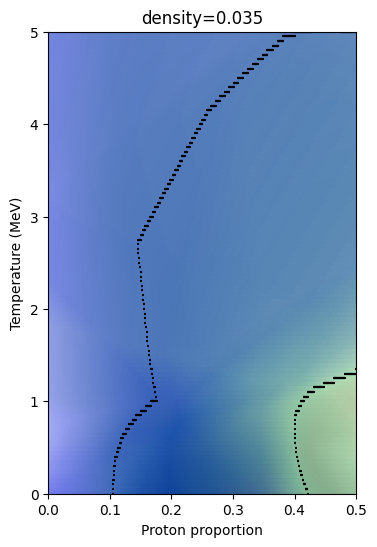

In [ ]:
generate_plot(density=0.035)
generate_plot(density=0.04)
generate_plot(density=0.045)
generate_plot(density=0.05)
generate_plot(density=0.055)
generate_plot(density=0.06)
generate_plot(density=0.065)
generate_plot(density=0.07)
generate_plot(density=0.075)
generate_plot(density=0.08)
generate_plot(density=0.085)
generate_plot(density=0.09)
generate_plot(density=0.095)

In [ ]:
generate_other_plot(density=0.035)
generate_other_plot(density=0.04)
generate_other_plot(density=0.045)
generate_other_plot(density=0.05)
generate_other_plot(density=0.055)
generate_other_plot(density=0.06)
generate_other_plot(density=0.065)
generate_other_plot(density=0.07)
generate_other_plot(density=0.075)
generate_other_plot(density=0.08)
generate_other_plot(density=0.085)
generate_other_plot(density=0.09)
generate_other_plot(density=0.095)